Variable explaination:
1. DistributionNetwork: refers to the organizational structure or channel strategy used to sell and manage insurance policies.
- Bancassurance: Partnership between banks and insurers, Bank employees or systems sell insurance alongside banking services.
- Broker Network: Independent brokers represent customers, not insurers
- Direct: Direct No intermediaries — customers buy from the insurer via website/app
2. DistributionChannel: describes the specific route or medium used to distribute an insurance product to a customer. It sits within a DistributionNetwork.
- Bank Branches: Insurance sold by bank employees or systems
- Headquarters: Headquarters No intermediaries — customers buy from the insurer via website/app
- CDW: Customer Direct Web
- CSU: Customer Service Unit
- BRU: Branch Unit
- MKG: Marketing Group
- XPA: External Partners/Agents
3. CommissionScheme: payment model used to compensate brokers for selling or managing insurance policies.
- Comm-2: 2% of premium
- Bonus Based = performance-driven incentives
4. PolicyInceptionDate: The date when the policy was first created, regardless of how many times it’s been renewed or modified.
5. CancelationDate: The date the policy was terminated (by either the customer or the insurer).
6. PolicyStartDate: The date a particular coverage period begins — can be different from PolicyInceptionDate in case of renewals.
7. PolicyEndDate: The date a particular coverage period ends.
8. AnnualizedPolicyPremium: This is the total premium income that the insurance company expects to earn from the policy on an annual basis.
9. LastForecastAmount: This is the most recent estimated cost of a claim — either before it's settled or as an updated projection based on claim evolution.


## I. Data Import

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read the CSV files
brokers = pd.read_csv("c:\\Code\\HELLOWORLD\\Python\\Bigdata\\Group_project\\Brokers.csv")
policies = pd.read_csv("c:\\Code\\HELLOWORLD\\Python\\Bigdata\\Group_project\\Policies.csv")
claims = pd.read_csv("c:\\Code\\HELLOWORLD\\Python\\Bigdata\\Group_project\\Claims_Announce.csv")

# Convert date columns
claims['AnnouncementDate'] = pd.to_datetime(claims['AnnouncementDate'])
claims['ClosingDate'] = pd.to_datetime(claims['ClosingDate'], errors='coerce')
policies['PolicyInceptionDate'] = pd.to_datetime(policies['PolicyInceptionDate'])

# Merge claims with brokers (using BrokerID supplied in claims)
claims_brokers = pd.merge(claims, brokers, on="BrokerID", how="left")

# Calculate claim duration in days (if ClosingDate is available)
claims_brokers['ClaimDuration'] = (claims_brokers['ClosingDate'] - claims_brokers['AnnouncementDate']).dt.days

In [ ]:
claims_brokers.head()

## II. Data Exploration

### 1. DistributionNetwork

C:\Users\LENOVO LEGION\AppData\Local\Temp\ipykernel_19048\3148260980.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=network_summary, x='DistributionNetwork', y='AvgPremium', palette='Blues_d', ax=axs[0])


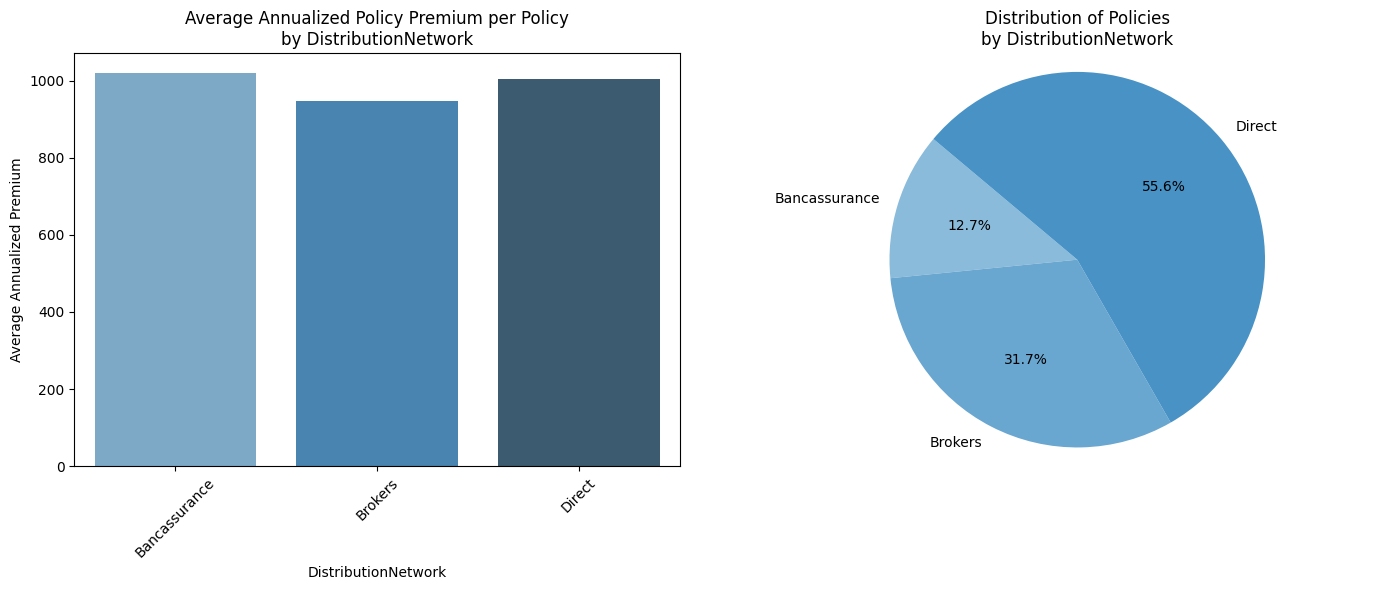

In [4]:
# Merge policies with brokers to get the DistributionNetwork for each policy.
policy_with_network = pd.merge(
    policies,
    brokers[['BrokerID', 'DistributionNetwork']],
    on='BrokerID',
    how='left'
)

# Group by DistributionNetwork: compute total number of policies and total premium
network_summary = policy_with_network.groupby('DistributionNetwork').agg(
    PolicyCount=('PolicyID', 'count'),
    TotalPolicyPremium=('AnnualizedPolicyPremium', 'sum')
).reset_index()

# Compute the average premium per policy for each network
network_summary['AvgPremium'] = network_summary['TotalPolicyPremium'] / network_summary['PolicyCount']

# Compute percentage distribution for the pie chart
network_summary['Percentage'] = network_summary['PolicyCount'] / network_summary['PolicyCount'].sum() * 100

# Create the figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Left: Bar chart – Average Annualized Policy Premium per Policy by DistributionNetwork
sns.barplot(data=network_summary, x='DistributionNetwork', y='AvgPremium', palette='Blues_d', ax=axs[0])
axs[0].set_title('Average Annualized Policy Premium per Policy\nby DistributionNetwork')
axs[0].set_xlabel('DistributionNetwork')
axs[0].set_ylabel('Average Annualized Premium')
axs[0].tick_params(axis='x', rotation=45)

# Right: Pie chart – Distribution of Policies by DistributionNetwork (Percentage)
axs[1].pie(
    network_summary['PolicyCount'],
    labels=network_summary['DistributionNetwork'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('Blues_d')
)
axs[1].set_title('Distribution of Policies\nby DistributionNetwork')
axs[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.show()

1. Description
- The Direct channel writes over half of all policies (~55.6%), indicates a high volume of business done directly with customers (via Tele sales, Headquarters and XPA). But its average premium per policy is slightly lower than Bancassurance.
- While only 12.7% of policies come from Bancassurance, the average premium is the highest indicating this channel offer a more premium service and bring more profit margin.
2. Analytical Insights
- Bancassurance channel delivers high premiums and high profit margin, it could be a growth opportunity to expand this channel.
- Brokers channel bring lower average premiums per contracts, the company should identify and promote top-performing brokers and flag loss-making brokers to improve this channel's profit margin.

C:\Users\LENOVO LEGION\AppData\Local\Temp\ipykernel_19048\22859225.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dn_summary, x="DistributionNetwork", y="ClaimsPerPolicy", palette="viridis", ax=axs[0])


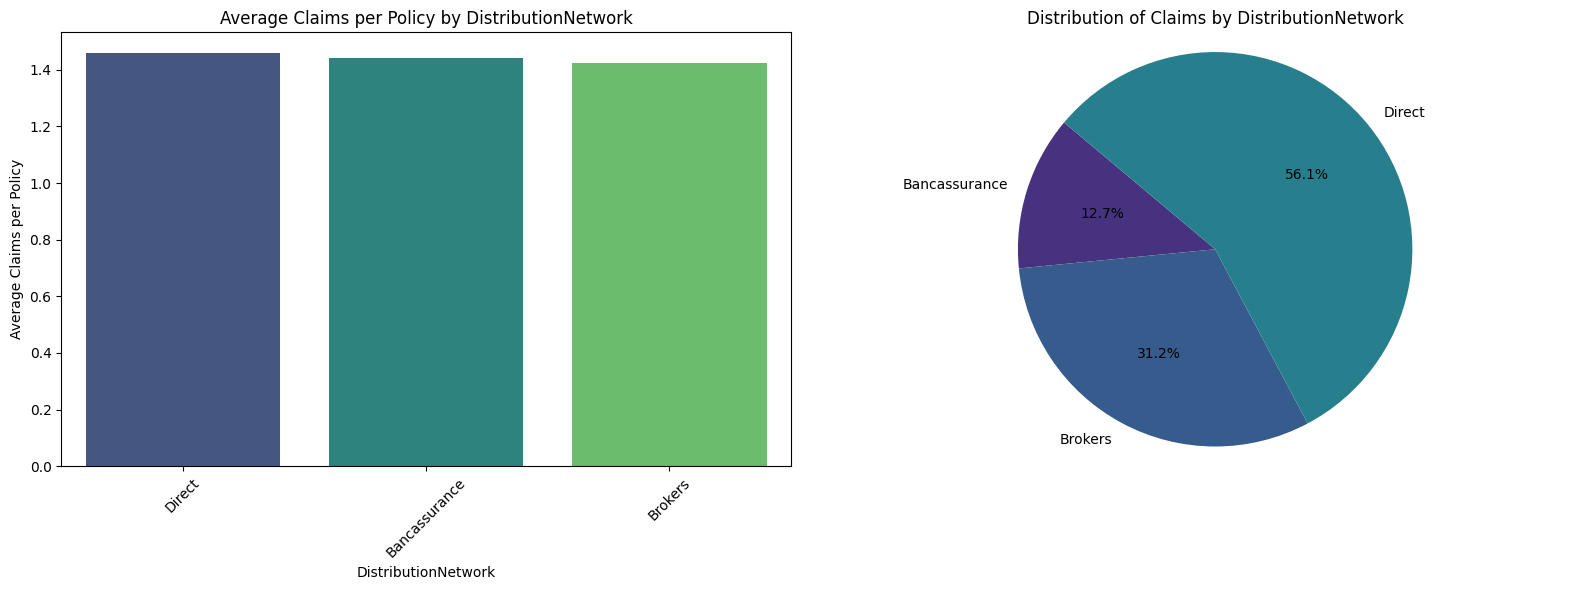

In [6]:
# --- Compute metrics for average claims per policy by DistributionNetwork ---

# Merge policies with brokers to get DistributionNetwork for each policy.
policy_with_network = pd.merge(
    policies,
    brokers[['BrokerID', 'DistributionNetwork']],
    on='BrokerID',
    how='left'
)

# Group by DistributionNetwork: count number of policies.
policy_counts = policy_with_network.groupby('DistributionNetwork').size().reset_index(name='PolicyCount')

# Group by DistributionNetwork: count number of claims from claims_brokers.
claims_counts = claims_brokers.groupby('DistributionNetwork').size().reset_index(name='ClaimCount')

# Merge to create a combined summary.
dn_summary = pd.merge(claims_counts, policy_counts, on='DistributionNetwork', how='inner')

# Calculate average number of claims per policy.
dn_summary['ClaimsPerPolicy'] = dn_summary['ClaimCount'] / dn_summary['PolicyCount']

# Sort by average claims per policy.
dn_summary = dn_summary.sort_values("ClaimsPerPolicy", ascending=False)

# For the pie chart: use the original distribution of claims.
dn_counts = claims_brokers.groupby('DistributionNetwork').size()

# Create the figure with two subplots.
fig, axs = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]})

# Left: Bar Chart – Average Claims per Policy by DistributionNetwork
sns.barplot(data=dn_summary, x="DistributionNetwork", y="ClaimsPerPolicy", palette="viridis", ax=axs[0])
axs[0].set_title("Average Claims per Policy by DistributionNetwork")
axs[0].set_xlabel("DistributionNetwork")
axs[0].set_ylabel("Average Claims per Policy")
axs[0].tick_params(axis='x', rotation=45)

# Right: Pie Chart – Distribution of Claims by DistributionNetwork (Percentage)
axs[1].pie(dn_counts, labels=dn_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis"))
axs[1].set_title("Distribution of Claims by DistributionNetwork")
axs[1].axis('equal')  # Ensures the pie chart is circular.

plt.tight_layout()
plt.show()

1. Description
- Higher number of policy also mean higher number of claims.
- Direct channel is responsible for 56.1% of claims (~7,700 claims). Bancassurance shows the smallest share only 12.7% (~1,750 claims).
- The direct channel having a slightly higher average number of claims per policy, however the different is not that significant. But this could indicate that the direct channel offer a lower qualitily of contract and customers tend to claims more often which can lead to a lower profit for the company.
2. Analytical Insights
- All channels, especially the direct channel can improve their contract's quality to lower the number of claims and increase the profit margin.


### 2. DistributionChannel

  DistributionChannel  PolicyCount  TotalPolicyPremium  ClaimCount  \
0                 BRU          238           256582.30         331   
1       Bank Branches          392           444468.29         593   
2                 CDW         1430          1293863.94        2058   
3                 CSU          999           969150.78        1418   
4        Headquarters         2127          2292824.23        3173   
5                 MKG          341           327491.47         474   
6          Tele sales         2606          2496989.95        3729   
7         Web banking          375           335118.63         530   
8                 XPA          976           947951.74        1406   

   TotalForecastAmount  ClaimPerPolicy  ForecastPerPolicy  PremiumPerPolicy  
0           1229138.63        1.390756        5164.448025       1078.076891  
1           2590018.16        1.512755        6607.189184       1133.847679  
2           6156626.96        1.439161        4305.333538        

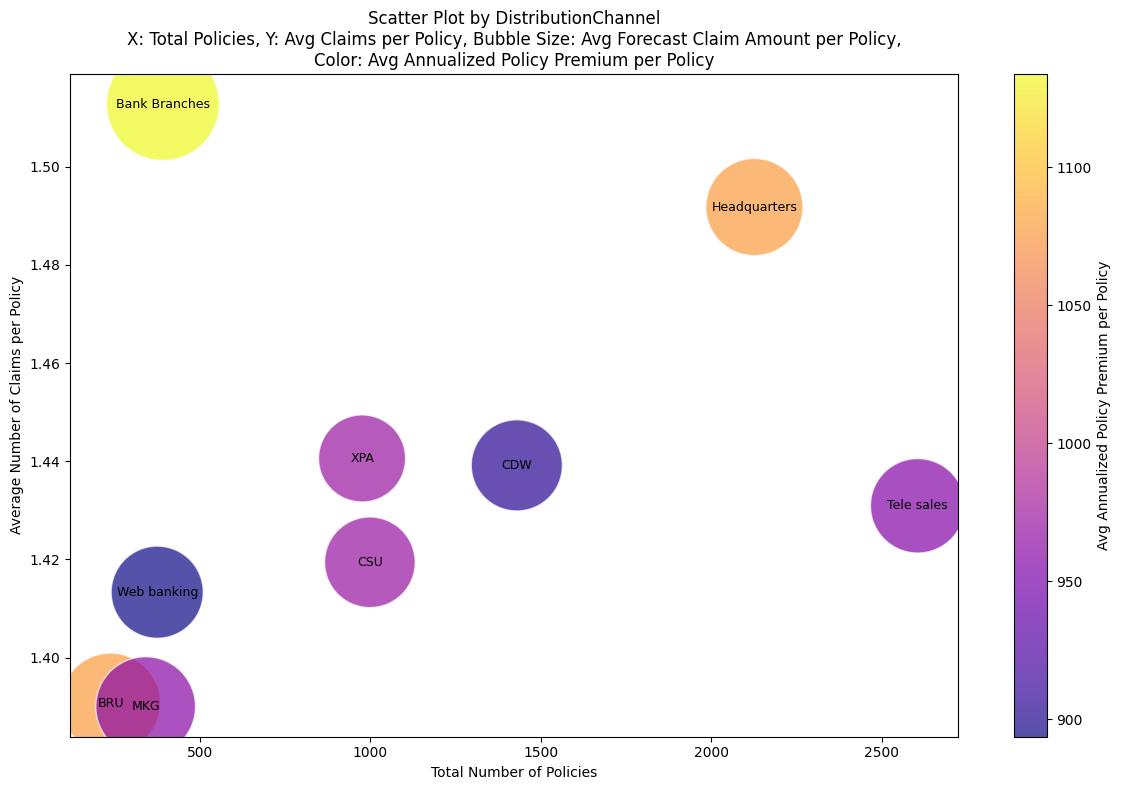

In [15]:
# Merge the policies with brokers to obtain each policy's DistributionChannel.
# This allows us to compute policy-related metrics per channel.
policy_with_channel = pd.merge(
    policies, 
    brokers[['BrokerID', 'DistributionChannel']], 
    on='BrokerID', 
    how='left'
)

# --- Compute aggregated metrics per DistributionChannel ---
policy_summary = policy_with_channel.groupby('DistributionChannel').agg(
    PolicyCount=('PolicyID', 'count'),
    TotalPolicyPremium=('AnnualizedPolicyPremium', 'sum')
).reset_index()

claims_summary = claims_brokers.groupby('DistributionChannel').agg(
    ClaimCount=('ClaimID', 'count'),
    TotalForecastAmount=('LastForecastAmount', 'sum')
).reset_index()

# Combine the policy and claims summaries.
channel_summary = pd.merge(policy_summary, claims_summary, on='DistributionChannel', how='outer')

# Compute per-policy averages:
channel_summary['ClaimPerPolicy'] = channel_summary['ClaimCount'] / channel_summary['PolicyCount']
channel_summary['ForecastPerPolicy'] = channel_summary['TotalForecastAmount'] / channel_summary['PolicyCount']
channel_summary['PremiumPerPolicy'] = channel_summary['TotalPolicyPremium'] / channel_summary['PolicyCount']

# Inspect the combined summary (optional)
print(channel_summary)

# --- Create the scatter plot with adjusted axes and annotations ---
plt.figure(figsize=(12,8))
scale_factor = 1  # adjust factor to scale bubble sizes

scatter = plt.scatter(
    x=channel_summary['PolicyCount'],                        # x: total number of policies 
    y=channel_summary['ClaimPerPolicy'],                     # y: average number of claims per policy
    s=channel_summary['ForecastPerPolicy'] * scale_factor,   # bubble size: avg forecast claim amount per policy
    c=channel_summary['PremiumPerPolicy'],                   # bubble color: avg annualized policy premium per policy
    cmap='plasma',
    alpha=0.7,
    edgecolors='w'
)

plt.xlabel("Total Number of Policies")
plt.ylabel("Average Number of Claims per Policy")
plt.title("Scatter Plot by DistributionChannel\nX: Total Policies, Y: Avg Claims per Policy, Bubble Size: Avg Forecast Claim Amount per Policy,\nColor: Avg Annualized Policy Premium per Policy")

# Add a color bar to represent the average annualized premium per policy.
cbar = plt.colorbar(scatter)
cbar.set_label("Avg Annualized Policy Premium per Policy")

# Annotate each point with its DistributionChannel, centered inside the bubble.
for i, row in channel_summary.iterrows():
    plt.annotate(
        row['DistributionChannel'],
        xy=(row['PolicyCount'], row['ClaimPerPolicy']),
        xytext=(0, 0),  # no offset so text is centered
        textcoords='offset points',
        ha='center',
        va='center',
        fontsize=9,
        color='black'
    )

plt.tight_layout()
plt.show()

1. Description 
- High-Claim Channels with High Premiums:
- Bank Branches has the highest avg. number of claims per policy (~1.51) and a very high avg. forecast claim amount per policy (~1,000). This indicatates that high-touch, personalized sales (like bank branches) attract customers with complex policies and higher risk exposure but also brings the highest avg. annualized policy premiums.
- Headquaters has a High total policies (~2000), High avg. claims per policy (~1.49). This indicate centralized channels might handle more complex or tailored policy setups, explaining both the higher premiums and claim rates.

- Efficient Channels:
- Tele Sales has the Highest number of policies (~2600) with lower avg. claims per policy (~1.43) and moderate premiums and forecast claim amount. Tele sales appears to be the channel to atract the most customer with efficient—large volumes with manageable risk and average claim values. A good balance between scale and cost.
- The same goes for XPA, CDW, and CSU but they all have lower customers.

- Low Risk / Low Volume Channels:
- MKG and Web Banking Possibly attracting more price-sensitive clients who file more claims, despite paying lower premiums.
- BRU (Branch Unit) might be a hidden gem when eventhough it has has slightly higher claim amount but offer much better annual premium.

2. Analysis Insight
- Channels like Bank Branches and Headquarters can be marketed as premium services—targeting high-value, high-need clients.
- Tele Sales is ideal for mass-market outreach with good cost-control and risk levels.
- Web Banking and MKG might need refinement in underwriting or fraud detection due to higher claim rates despite lower premiums.
- Investigate and grow promising niche channels like BRU.

### 3. CommissionScheme

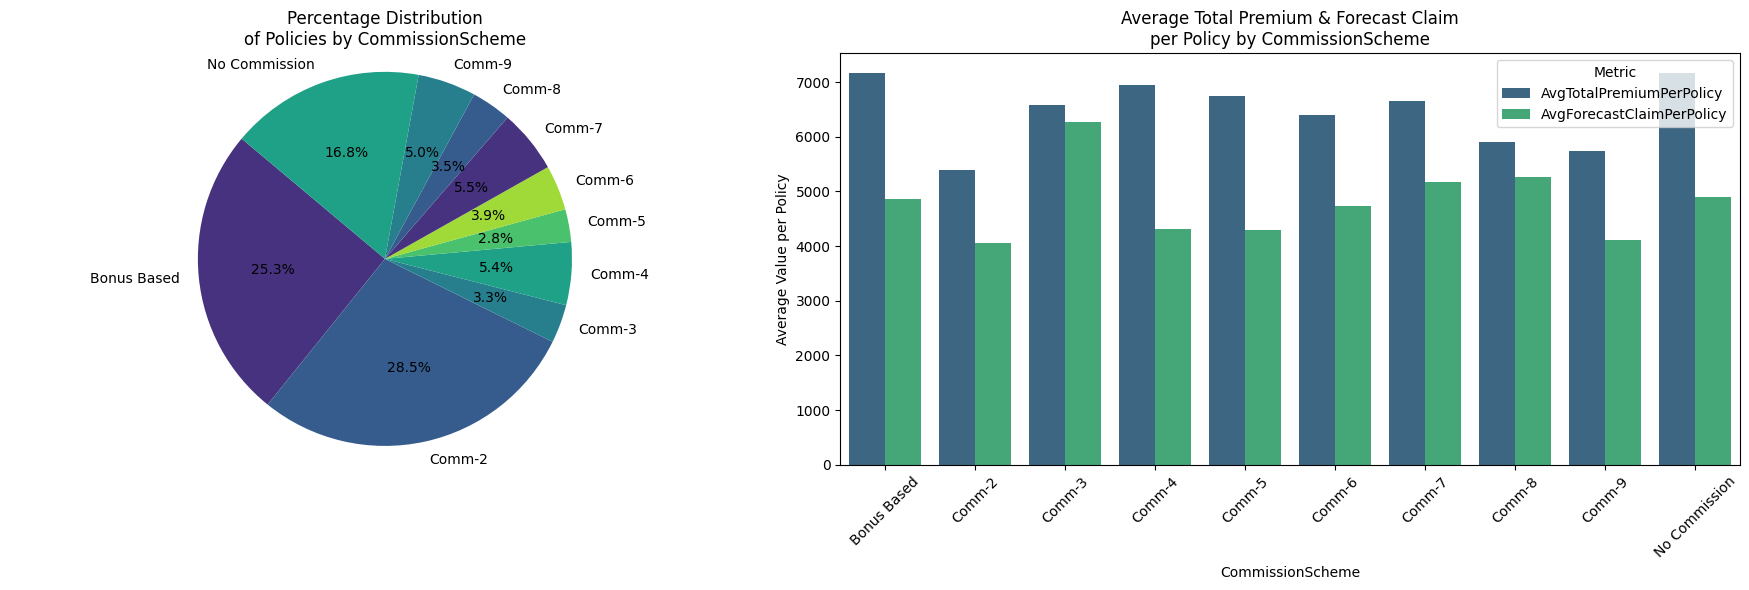

In [19]:
# Assuming today is 01/01/2021
today = pd.Timestamp('2021-01-01')

# Merge policies with brokers to get CommissionScheme
policy_with_cs = pd.merge(
    policies,
    brokers[['BrokerID', 'CommissionScheme']],
    on='BrokerID',
    how='left'
)

# Convert CancelationDate to datetime (assuming the column exists)
policy_with_cs['CancelationDate'] = pd.to_datetime(policy_with_cs['CancelationDate'], errors='coerce')

# Compute effective end date:
# If CancelationDate is 31/12/2099 (policy still active), use today; otherwise use CancelationDate.
policy_with_cs['EffectiveEndDate'] = policy_with_cs['CancelationDate'].apply(
    lambda x: today if x == pd.Timestamp('2099-12-31') else x
)

# Calculate duration in years for each policy
policy_with_cs['Duration'] = (policy_with_cs['EffectiveEndDate'] - policy_with_cs['PolicyInceptionDate']).dt.days / 365.25

# Calculate the Total Premium per Policy (annualized premium * duration)
policy_with_cs['TotalPremiumPolicy'] = policy_with_cs['AnnualizedPolicyPremium'] * policy_with_cs['Duration']

# Group by CommissionScheme to compute total premium and policy count.
cs_total = policy_with_cs.groupby('CommissionScheme').agg(
    PolicyCount=('PolicyID', 'count'),
    SumTotalPremium=('TotalPremiumPolicy', 'sum')
).reset_index()

# Compute the average Total Premium per Policy.
cs_total['AvgTotalPremiumPerPolicy'] = cs_total['SumTotalPremium'] / cs_total['PolicyCount']

# Compute total forecast claim amount from claims_brokers by CommissionScheme.
claims_forecast = claims_brokers.groupby('CommissionScheme').agg(
    TotalForecastAmount=('LastForecastAmount', 'sum')
).reset_index()

# Merge total premium and forecast claim data.
cs_forecast = pd.merge(cs_total, claims_forecast, on='CommissionScheme', how='left')

# Compute average Forecast Claim per Policy.
cs_forecast['AvgForecastClaimPerPolicy'] = cs_forecast['TotalForecastAmount'] / cs_forecast['PolicyCount']

# Convert data to long format for grouped bar chart (right chart)
cs_long = cs_forecast.melt(
    id_vars='CommissionScheme', 
    value_vars=['AvgTotalPremiumPerPolicy', 'AvgForecastClaimPerPolicy'],
    var_name='Metric',
    value_name='Value'
)

# Prepare data for the pie chart (percentage distribution of policies by CommissionScheme)
cs_pie = policy_with_cs.groupby('CommissionScheme').agg(
    PolicyCount=('PolicyID', 'count')
).reset_index()
cs_pie['Percentage'] = cs_pie['PolicyCount'] / cs_pie['PolicyCount'].sum() * 100

# Create the figure with two subplots:
# Left: Pie Chart – Percentage Distribution of Policies by CommissionScheme
# Right: Grouped Bar Chart – Average Total Premium & Forecast Claim per Policy by CommissionScheme
fig, axs = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1.2]})

# Left: Pie Chart
axs[0].pie(
    cs_pie['PolicyCount'], 
    labels=cs_pie['CommissionScheme'], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=sns.color_palette('viridis')
)
axs[0].set_title("Percentage Distribution\nof Policies by CommissionScheme")
axs[0].axis('equal')  # Ensure pie chart is circular.

# Right: Grouped Bar Chart
sns.barplot(
    data=cs_long, 
    x='CommissionScheme', 
    y='Value', 
    hue='Metric', 
    palette='viridis', 
    ax=axs[1]
)
axs[1].set_title("Average Total Premium & Forecast Claim\nper Policy by CommissionScheme")
axs[1].set_xlabel("CommissionScheme")
axs[1].set_ylabel("Average Value per Policy")
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

1. Description
- The highest number of policies come from Comm-2 (28.5%), Bonus Based (25.3%), No Commission (16.8%) indication that most customers still prefer to buy policies with little to no or negotiable brokerage commission.
- Comm-2 attracts volume but at lower premium/claim values. Likely a mass-market, low-margin approach.
- Bonus Based and No Commission have a higher premium/claim value and has excellent for revenue growth with controlled loss ratio.
- Comm-3 has the worst premium/claim ratio. Similar case for Comm-8.

2. Analysis Insights
- Bonus Based and No Commission has very high premium, high profit margin. So, the company should scale it or use it for flagship or profitable products.
- Comm-2 has High Volume, Low Margin so the company should condider optimizing pricing or automate underwriting to improve margin.
- Comm-3 and Comm-8 perform the worst so the company should evaluate risk pool or refine pricing

C:\Users\LENOVO LEGION\AppData\Local\Temp\ipykernel_19048\1460754768.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=claims_no_outliers, x="CommissionScheme", y="ClaimDuration", palette="Set2")


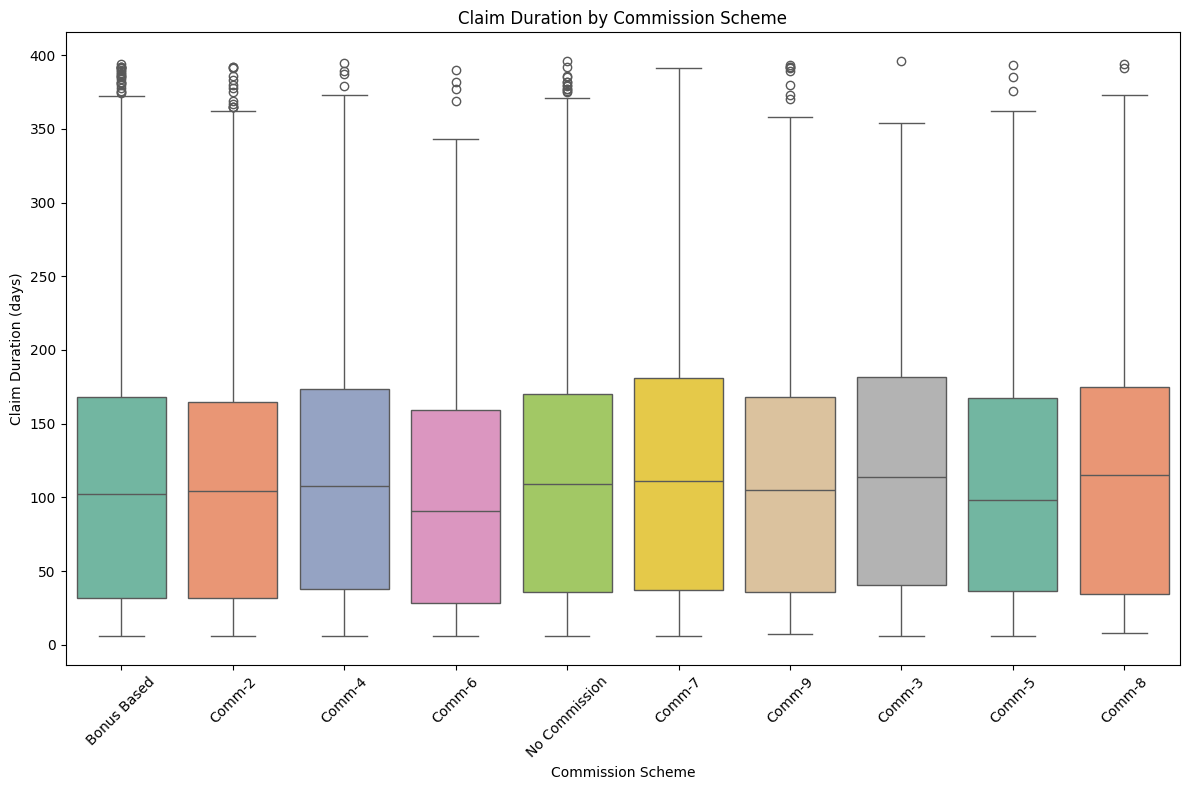

In [23]:
# Filter out ongoing policies: when ClosingDate equals 31/12/2099
# This means the policy is still on-going and should not be used in duration calculations.
filtered_claims = claims_brokers[claims_brokers['ClosingDate'] != pd.to_datetime("2099-12-31")]

# Remove the top and bottom 2% of ClaimDuration values
lower_bound = filtered_claims['ClaimDuration'].quantile(0.02)
upper_bound = filtered_claims['ClaimDuration'].quantile(0.98)
claims_no_outliers = filtered_claims[(filtered_claims['ClaimDuration'] >= lower_bound) & (filtered_claims['ClaimDuration'] <= upper_bound)]

# Create the boxplot of ClaimDuration grouped by CommissionScheme using the trimmed data.
plt.figure(figsize=(12,8))
sns.boxplot(data=claims_no_outliers, x="CommissionScheme", y="ClaimDuration", palette="Set2")
plt.title("Claim Duration by Commission Scheme")
plt.xlabel("Commission Scheme")
plt.ylabel("Claim Duration (days)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. Description
- Comm-6, Comm-9, Comm-2 has Faster Claims Processing compare to the others, however, there is not a clear trend on higher commision cost lead to faster claims processing.
2. Analysis Insights
- Policies with higher commission cost should be prioritized for claims processing to better serve the customers.

### 4. Brokers

C:\Users\LENOVO LEGION\AppData\Local\Temp\ipykernel_9428\921774726.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_policies, x="BrokerFullName", y="PolicyCount", palette="Blues_d")


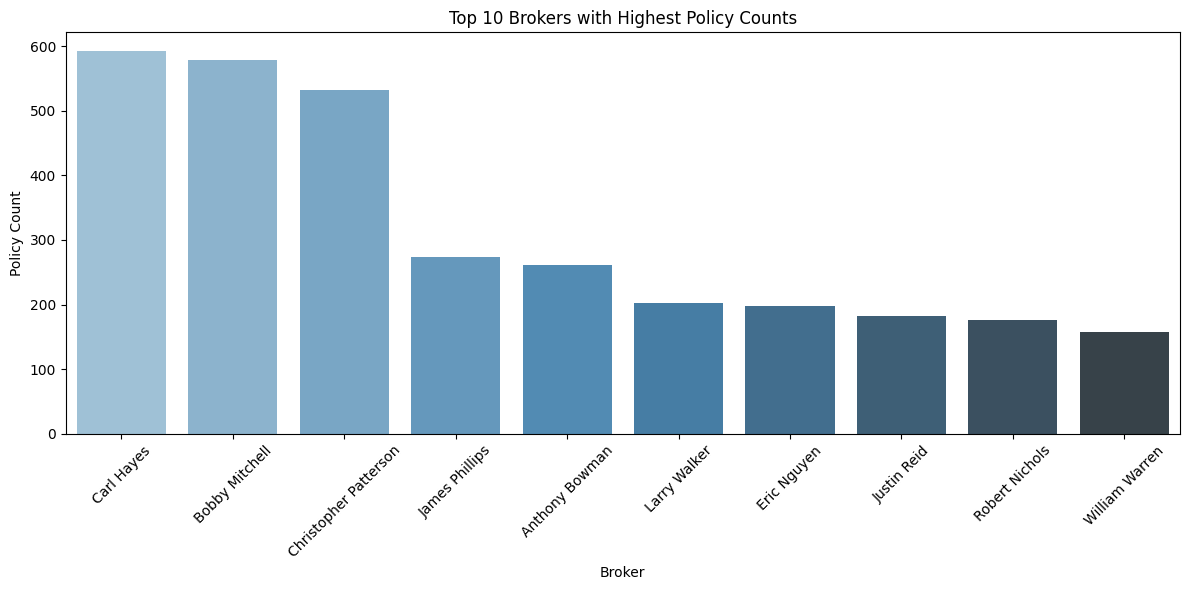

In [ ]:
# Top 10 Brokers with Highest Policy Counts
# Group policies by BrokerID then join with brokers to get BrokerFullName.
policy_counts = policies.groupby('BrokerID').size().reset_index(name='PolicyCount')
policy_counts = pd.merge(policy_counts, brokers[['BrokerID','BrokerFullName']], on='BrokerID', how='left')
top10_policies = policy_counts.sort_values("PolicyCount", ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=top10_policies, x="BrokerFullName", y="PolicyCount", palette="Blues_d")
plt.xticks(rotation=45)
plt.title("Top 10 Brokers with Highest Policy Counts")
plt.xlabel("Broker")
plt.ylabel("Policy Count")
plt.tight_layout()
plt.show()

1. Description
- Carl Hayes, Bobby Mitchell, and Christopher Patterson are significantly ahead in policy volume (>500 each).
- A visible cliff occurs after the top three brokers; the 4th-ranked broker (James Phillips) has almost half the count of Carl Hayes.
2. Analysis Insights
- Focus coaching, CRM tools, or incentives on mid-performing brokers to close the gap.

C:\Users\LENOVO LEGION\AppData\Local\Temp\ipykernel_9428\1090462516.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_high_cost, x="AvgClaimCost", y="BrokerFullName", palette="Reds_d", ax=axs[0])
C:\Users\LENOVO LEGION\AppData\Local\Temp\ipykernel_9428\1090462516.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_low_cost, x="AvgClaimCost", y="BrokerFullName", palette="Greens_d", ax=axs[1])


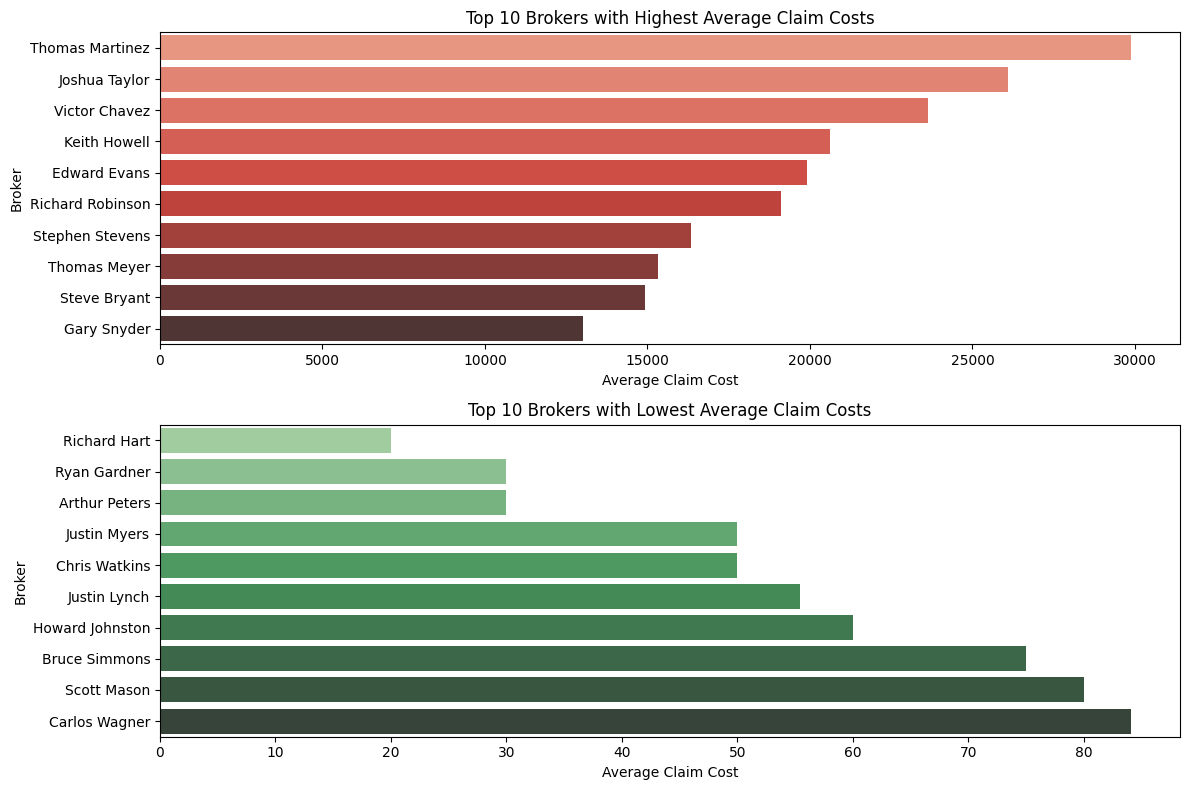

In [ ]:
# Top 10 Brokers with Lowest Average Claim Costs
avg_claim_cost = claims_brokers.groupby('BrokerID')['LastForecastAmount'].mean().reset_index(name='AvgClaimCost')
avg_claim_cost = pd.merge(avg_claim_cost, brokers[['BrokerID','BrokerFullName']], on='BrokerID', how='left')

# Get the top 10 lowest average claim costs
top10_low_cost = avg_claim_cost.sort_values("AvgClaimCost", ascending=True).head(10)

# Get the top 10 highest average claim costs
top10_high_cost = avg_claim_cost.sort_values("AvgClaimCost", ascending=False).head(10)

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# Top 10 Brokers with Highest Average Claim Costs
sns.barplot(data=top10_high_cost, x="AvgClaimCost", y="BrokerFullName", palette="Reds_d", ax=axs[0])
axs[0].set_title("Top 10 Brokers with Highest Average Claim Costs")
axs[0].set_xlabel("Average Claim Cost")
axs[0].set_ylabel("Broker")

# Top 10 Brokers with Lowest Average Claim Costs
sns.barplot(data=top10_low_cost, x="AvgClaimCost", y="BrokerFullName", palette="Greens_d", ax=axs[1])
axs[1].set_title("Top 10 Brokers with Lowest Average Claim Costs")
axs[1].set_xlabel("Average Claim Cost")
axs[1].set_ylabel("Broker")

# Layout so plots do not overlap
fig.tight_layout()

plt.show()

1. Description
- Thomas Martinez, Joshua Taylor, and Victor Chavez top the list with average claim costs of ~30,000, 26,000, and 23,000+ respectively. These brokers are potentially handling high-risk or high-value policies, or could be associated with inefficiencies, fraud, or overestimation in claim evaluations.
- Brokers like Richard Hart, Ryan Gardner, and Arthur Peters report average claim costs below $30–$40 — exceptionally low. These brokers may serve low-risk demographics, short-term policies, or microinsurance products.
2. Analysis Insights
- Brokers with extreme values on either end (especially high average costs) should be reviewed for: Claim inflation, Misclassification and Delayed claim closures.

C:\Users\LENOVO LEGION\AppData\Local\Temp\ipykernel_9428\1841823026.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_freq, x="ClaimFrequency", y="BrokerFullName", palette="Oranges_d", ax=axs[0])
C:\Users\LENOVO LEGION\AppData\Local\Temp\ipykernel_9428\1841823026.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_cost_policy, x="CostPerPolicy", y="BrokerFullName", palette="Reds_d", ax=axs[1])


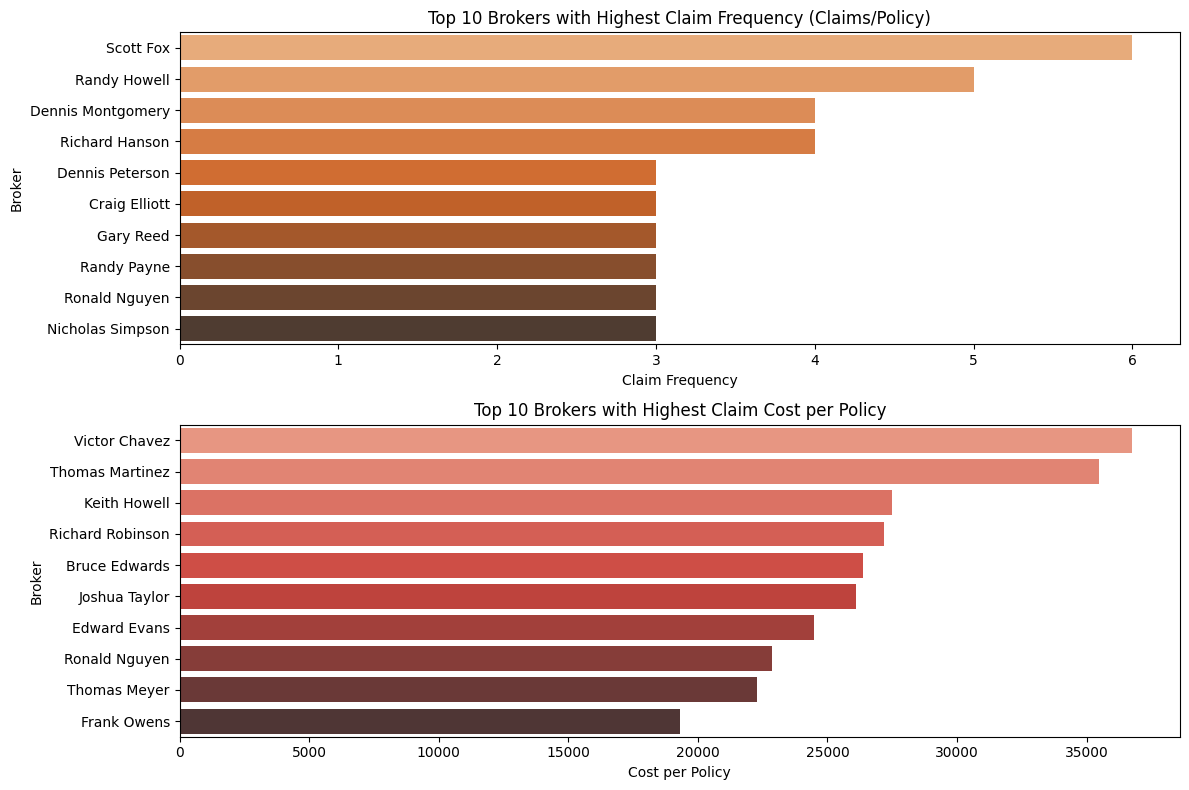

In [ ]:
# Top 10 Brokers with Highest Frequency of Claims Relative to Number of Policies
claims_per_broker = claims_brokers.groupby('BrokerID').size().reset_index(name='ClaimCount')
policy_counts = policies.groupby('BrokerID').size().reset_index(name='PolicyCount')
freq_df = pd.merge(claims_per_broker, policy_counts, on='BrokerID', how='inner')
freq_df['ClaimFrequency'] = freq_df['ClaimCount'] / freq_df['PolicyCount']
freq_df = pd.merge(freq_df, brokers[['BrokerID','BrokerFullName']], on='BrokerID', how='left')
top10_freq = freq_df.sort_values("ClaimFrequency", ascending=False).head(10)

# Top 10 Brokers with Highest Cost of Claims Relative to Number of Policies
total_cost_by_broker = claims_brokers.groupby('BrokerID')['LastForecastAmount'].sum().reset_index(name='TotalClaimCost')
cost_policy_df = pd.merge(total_cost_by_broker, policy_counts, on='BrokerID', how='inner')
cost_policy_df['CostPerPolicy'] = cost_policy_df['TotalClaimCost'] / cost_policy_df['PolicyCount']
cost_policy_df = pd.merge(cost_policy_df, brokers[['BrokerID','BrokerFullName']], on='BrokerID', how='left')
top10_cost_policy = cost_policy_df.sort_values("CostPerPolicy", ascending=False).head(10)

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# Top 10 Brokers with Highest Frequency of Claims Relative to Number of Policies
sns.barplot(data=top10_freq, x="ClaimFrequency", y="BrokerFullName", palette="Oranges_d", ax=axs[0])
axs[0].set_title("Top 10 Brokers with Highest Claim Frequency (Claims/Policy)")
axs[0].set_xlabel("Claim Frequency")
axs[0].set_ylabel("Broker")

# Top 10 Brokers with Highest Cost of Claims Relative to Number of Policies
sns.barplot(data=top10_cost_policy, x="CostPerPolicy", y="BrokerFullName", palette="Reds_d", ax=axs[1])
axs[1].set_title("Top 10 Brokers with Highest Claim Cost per Policy")
axs[1].set_xlabel("Cost per Policy")
axs[1].set_ylabel("Broker")

# Layout so plots do not overlap
fig.tight_layout()

plt.show()

1. Description
- Scott Fox has the highest claim frequency (~6 claims/policy). Others like Randy Howell and Dennis Montgomery also show notably high claim activity. These brokers' clients may frequently file claims — possibly due to high-risk policyholders (poor underwriting)
- Victor Chavez and Thomas Martinez top the list with ~$36K and ~$35K per policy respectively. This possibly insuring High-value assets or could reflect overestimation or fraud in claims processing.
- Ronald Nguyen appears in both charts: High frequency, High cost per policy.
2. Analysis Insights
- Brokers with high claim frequencies and high claim costs per policy should be reviewed for: Claim inflation, Misclassification and Delayed claim closures.

C:\Users\LENOVO LEGION\AppData\Local\Temp\ipykernel_9428\3709501015.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_loss, x="LossRatio", y="BrokerFullName", palette="Purples_d", ax=axs[0])
C:\Users\LENOVO LEGION\AppData\Local\Temp\ipykernel_9428\3709501015.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_profit, x="ProfitRatio", y="BrokerFullName", palette="Greens_d", ax=axs[1])


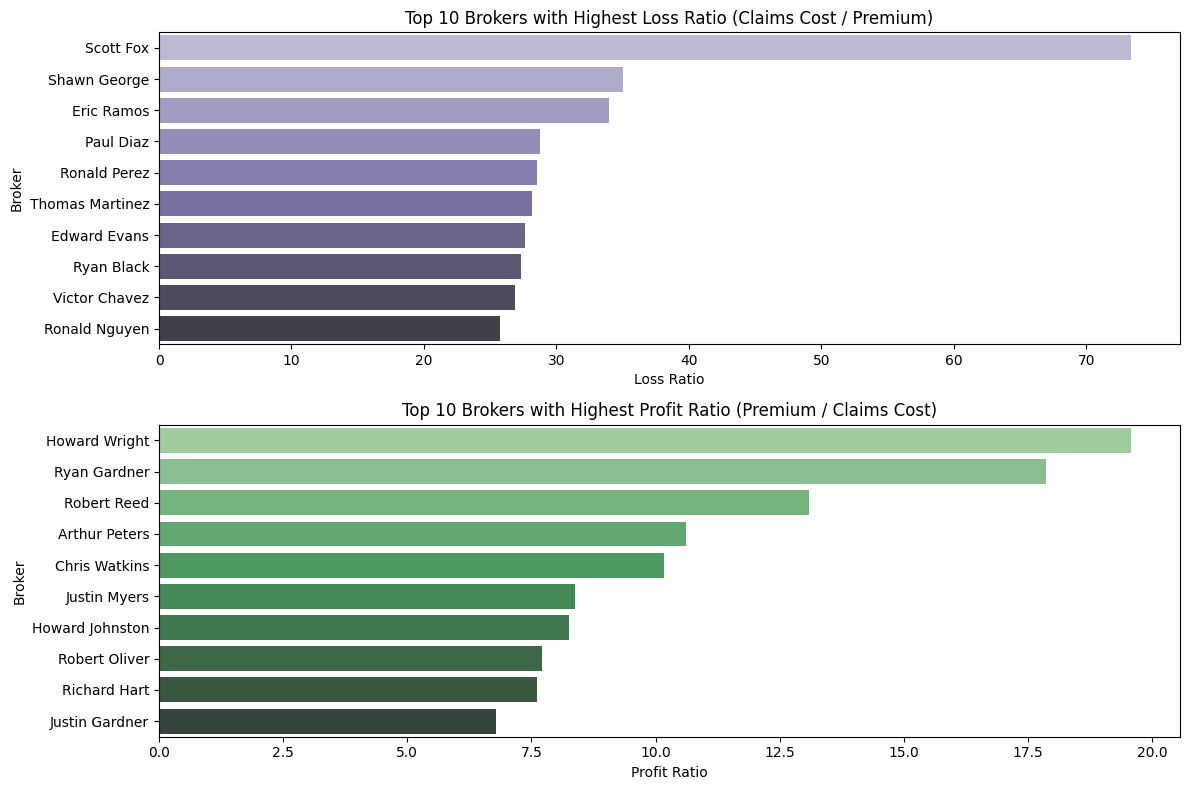

In [28]:
# 8. Loss Ratio per Broker: Total Claims Cost / Total Premium; Plot Top 10 brokers with highest loss ratio.
# Compute total claims cost per broker
claims_cost = claims_brokers.groupby('BrokerID')['LastForecastAmount'].sum().reset_index(name='TotalClaimCost')
# Compute total premium per broker from policies
premiums = policies.groupby('BrokerID')['AnnualizedPolicyPremium'].sum().reset_index(name='TotalPremium')
# Merge and compute loss ratio
loss_df = pd.merge(claims_cost, premiums, on='BrokerID', how='inner')
loss_df['LossRatio'] = loss_df['TotalClaimCost'] / loss_df['TotalPremium']
loss_df = pd.merge(loss_df, brokers[['BrokerID','BrokerFullName']], on='BrokerID', how='left')
top10_loss = loss_df.sort_values("LossRatio", ascending=False).head(10)

# Compute profit ratio
loss_df['ProfitRatio'] = loss_df['TotalPremium'] / loss_df['TotalClaimCost']
top10_profit = loss_df.sort_values("ProfitRatio", ascending=False).head(10)

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# Top 10 Brokers with Highest Loss Ratio
sns.barplot(data=top10_loss, x="LossRatio", y="BrokerFullName", palette="Purples_d", ax=axs[0])
axs[0].set_title("Top 10 Brokers with Highest Loss Ratio (Claims Cost / Premium)")
axs[0].set_xlabel("Loss Ratio")
axs[0].set_ylabel("Broker")

# Top 10 Brokers with Highest Profit Ratio
sns.barplot(data=top10_profit, x="ProfitRatio", y="BrokerFullName", palette="Greens_d", ax=axs[1])
axs[1].set_title("Top 10 Brokers with Highest Profit Ratio (Premium / Claims Cost)")
axs[1].set_xlabel("Profit Ratio")
axs[1].set_ylabel("Broker")

# Layout so plots do not overlap
fig.tight_layout()

plt.show()

1. Description
- Scott Fox has a staggering 73% loss ratio, far higher than peers. Shawn George and Eric Ramos follow with ~35% and ~33%.
- Brokers like Thomas Martinez, Victor Chavez, and Ronald Nguyen also appear here — familiar from earlier charts (cost/frequency).
- These brokers’ books are barely profitable or even loss-making which May result from: Poor underwriting, High-risk clientele, Soft pricing (discounted premiums), or Fraud in claims processing.
- Howard Wright achieves a profit ratio near 20, meaning the insurer earns 20x the claims cost in premiums.
- Ryan Gardner, Robert Reed, Arthur Peters — all show strong profitability (12–18x return).
2. Analysis Insights
- Persistent high loss ratios may signal organized fraud, especially if clustered by region or product type, insurers should review or suspend broker agreements if loss ratio are too high.
- On the other hand, brokers with high profit ratio should be considered increasing commissions or bonuses.